In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange
import numpy as np
from tflib.save_images import *

In [2]:
data_dir = './data'
import helper

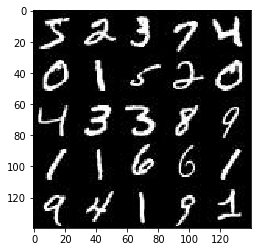

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

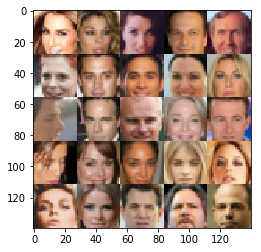

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

"""
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
"""

"\n# Check TensorFlow Version\nassert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)\nprint('TensorFlow Version: {}'.format(tf.__version__))\n\n# Check for a GPU\nif not tf.test.gpu_device_name():\n    warnings.warn('No GPU found. Please use a GPU to train your neural network.')\nelse:\n    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))\n"

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    fake_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_fake')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs, fake_imgs,inputs_z, learning_rate

In [7]:
HIDDEN_DIM = 1024
INPUT_DIM = 28 * 28 * 3
IMAGE_SHAPE = [28, 28, 3]

## Encoder

In [58]:
def encoder(images, z_dim, leaky_factor=0.2, name='encoder', reuse=False):
    """
    Create the encoder network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :leaky_factor: leaky_factor for leaky relu layer
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope(name, reuse=reuse):

        # Flatten it
        #norm = tf.random_normal_initializer(stddev=0.01)
        x1 = tf.contrib.layers.flatten(images)
        x1 = tf.layers.dense(x1, HIDDEN_DIM / 4)
        #x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        #relu1 = tf.maximum(leaky_factor * x1, x1)
        relu1 = tf.nn.relu(x1)
        #relu1 = tf.nn.sigmoid(x1)
        
        x2 = tf.layers.dense(relu1, HIDDEN_DIM / 4)
        #x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        #relu2 = tf.maximum(leaky_factor * x2, x2)
        relu2 = tf.nn.relu(x2)
        #relu2 = tf.nn.sigmoid(x2)

        
        out = tf.nn.relu(tf.layers.dense(relu2, z_dim))
        #out = tf.maximum(leaky_factor * out, out)
        return out

## Decoder

In [59]:
def decoder(z, out_channel_dim, leaky_factor=0.2, name='decoder',is_train=True):
    """
    Create the decoder network
    :param images: Tensor of input z
    :param out_channel_dim: the output channel format
    :param leaky_factor: leaky_factor for leaky relu layer
    :param is_train: Boolean if it is train mode or test mode
    :return: Tensor of output vector (latent z )
    """    
    with tf.variable_scope(name, reuse= (not is_train)):
        x1 = tf.layers.dense(z, HIDDEN_DIM / 4)
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        #relu1 = tf.maximum(leaky_factor * x1, x1)
        relu1 = tf.nn.relu(x1)
        #relu1 = tf.nn.sigmoid(x1)
        
        x2 = tf.layers.dense(relu1, HIDDEN_DIM / 4)
        #x2 = tf.layers.batch_normalization(x2, training=is_train)
        #relu2 = tf.maximum(leaky_factor * x2, x2)
        relu2 = tf.nn.relu(x2)
        #relu2 = tf.nn.sigmoid(x2)
       
        out = tf.tanh(tf.layers.dense(relu2, INPUT_DIM))
        #out = tf.nn.sigmoid(tf.layers.dense(relu2, INPUT_DIM))
        return tf.reshape(out, [-1] + IMAGE_SHAPE)

## Discriminator

In [60]:
def discriminator(input_z, leaky_factor=0.2, name='discriminator',reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input z
    :param leaky_factor: leaky_factor for leaky relu layer
    :param reuse: Boolean if it is train mode or test mode
    :return: tuple of (classification result, logits)
    """     
    with tf.variable_scope(name, reuse=reuse):
        
        x1 = tf.layers.dense(input_z, HIDDEN_DIM)
        #x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        #relu1 = tf.maximum(leaky_factor * x1, x1)
        relu1 = tf.nn.relu(x1)

        x2 = tf.layers.dense(relu1, HIDDEN_DIM)
        #x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        #relu2 = tf.maximum(leaky_factor * x2, x2)
        relu2 = tf.nn.relu(x2)

        logits = tf.layers.dense(x2, 1)
        out = tf.sigmoid(logits)

        return out, logits

## Corruptor

In [61]:
def corrupt(images, mask_type='inpainting',noise=False):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.get_shape().as_list()[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.5
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    if noise:
        images = tf.add(images, gnoise)
        
    if mask_type == 'inpainting':
        # inpainting 
        a, b = 2, 2
        pixFrac = np.random.beta(a,b)
        #pixFrac = 0.5
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = tf.multiply(images, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = tf.contrib.layers.flatten(images)
        #A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        #A = np.array(A, dtype=np.float32)
        #mask = np.matmul(A.transpose(), A)
        A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        mask = tf.matmul(tf.transpose(A), A)
        result = tf.matmul(flat_images, mask)
        return tf.reshape(result, [-1] + image_shape)
    else:
        return images
    
    
def corrupt_func(images, mask_type='inpainting',noise=True):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.shape[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.5
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    result = np.zeros(images.shape)
    result += images
    if noise:
        result += gnoise
        
    if mask_type == 'inpainting':
        # inpainting 
        #a, b = 2, 2
        #pixFrac = np.random.beta(a,b)
        pixFrac = 0.2
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = np.multiply(result, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = np.array(list(map(lambda x: x.flatten(), result)))
        
        A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        A = np.array(A, dtype=np.float32)
        mask = np.matmul(A.transpose(), A)
        #A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        #mask = tf.matmul(tf.transpose(A), A)
        #result = tf.matmul(flat_images, mask)
        result = np.array(list(map(lambda x : np.matmul(x, mask), flat_images)))
        return result.reshape(images.shape)
    else:
        return result

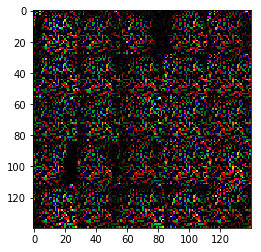

In [62]:
# test corrupt_func
A = corrupt_func(mnist_images, mask_type='inpainting', noise=False)
pyplot.imshow(helper.images_square_grid(A, 'RGB'))

### Loss
Implement `model_loss` to build the DAAE for training and calculate the loss.  The function should return a tuple of (discriminator loss, encoder loss, encoder-decoder loss).  Use the following functions you implemented:
- `discriminator(input_z, leaky_factor, reuse=False)`
- `decoder(z, out_channel_dim, leaky_factor, is_train=True)`
- `encoder(images, z_dim, leaky_factor, reuse=False)`

In [63]:
def model_loss(input_real, input_fake, input_z, z_dim, output_channel_dim):
    """
    Get the loss for the discriminator, encoder and decoder
    :param input_real: Images from the real dataset
    :param input_z: Z input from Laplacian distribution
    :param out_channel_dim: The number of channels in the output image
    :param M : how many iterations to sample from p(z|x)
    :return: A tuple of (discriminator loss, encoder loss, recon loss, dis_loss_sum, en_loss_sum, recon_loss_sum)
    """
    
    En = encoder(input_real, z_dim, name='en_real')
    De = decoder(En, output_channel_dim, name='decoder')
    
    recon_loss = tf.reduce_mean(tf.square(tf.subtract(De, input_real))) #+ 0.01 * tf.reduce_sum(tf.abs(En))
    
    """
    recon_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=De,
                labels=input_real))
    """
    
    """    
    d_out_real, d_logits_real = discriminator(En)  

    encorr = encoder(input_fake, z_dim, name='en_fake')
    reconstruction = decoder(encorr, output_channel_dim, is_train=False)
    
    en_recon_loss = tf.reduce_mean(tf.square(tf.subtract(reconstruction, input_real)))
    
    
    d_out_fake, d_logits_fake = discriminator(encorr, reuse=True)

        
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.zeros_like(d_out_fake)))

    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_real,
                labels=tf.ones_like(d_out_real)))

    dis_loss = d_loss_fake + d_loss_real
    
    
    temp_en_loss_dis = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_out_fake)))
    
    temp_en_loss = tf.reduce_mean(tf.square(tf.subtract(En, encorr)))
    
    en_loss = 0 * temp_en_loss_dis + 0 * temp_en_loss + 0.2 * en_recon_loss
    """
    
    #temp_en_loss_sum = tf.summary.histogram("temp_en_loss_dis", temp_en_loss_dis)
    #dis_loss_sum = tf.summary.scalar("dis_loss", dis_loss)
    recon_loss_sum = tf.summary.scalar("recon_loss", recon_loss)
    #en_loss_sum = tf.summary.scalar("en_loss", en_loss)
    
    return De, recon_loss, recon_loss_sum
    
    

In [64]:
def model_opt(recon_loss, learning_rate, beta1, beta2):
    """
    Get optimization operations
    :param dis_loss: Discriminator loss Tensor
    :param en_loss: encoder loss Tensor
    :param recon_loss: reconstruction loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, encoder training operation, recontraining operations)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    #dis_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    de_vars = [var for var in t_vars if var.name.startswith('decoder')]
    en_real_vars = [var for var in t_vars if var.name.startswith('en_real')]
    #en_fake_vars = [var for var in t_vars if var.name.startswith('en_fake')]
    ed_vars = de_vars + en_real_vars
    
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='decoder')):
    #de_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(recon_loss, var_list=ed_vars)
    de_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(recon_loss, var_list=ed_vars)
    #d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(dis_loss, var_list=dis_vars)
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='encoder')):
    #en_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(en_loss, var_list=en_fake_vars)
    
    return de_train_opt





## Training

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import scipy.stats as stats
from skimage.measure import compare_psnr

from scipy.stats import sem
def mean_score(scores):
    return ("##### What? The Mean score: {0:.3f} (+/-{1: .3f})").format(np.mean(scores), sem(scores))


def sample_from_dis(n_images, z_dim,dis = 'laplacian'):
    if dis == 'laplacian':
        mu = 0.0
        lam = 1.0
        return np.random.laplace(loc=mu, scale=lam, size=[n_images, z_dim])
    elif dis == 'gaussian':
        mu = 0
        lower = -1
        upper = 1
        sigma = 1 / np.sqrt(z_dim)
        sigma = 1
        z = stats.truncnorm.rvs((lower-mu)/sigma, (upper-mu)/sigma, loc=mu, scale=sigma, size=[n_images,z_dim])
        return z
    else:
        return np.random.uniform(-1, 1, size=[n_images, z_dim])


def show_decoder_output(sess, n_images, input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    example_z = sample_from_dis(n_images, z_dim, dis=None)

    samples = sess.run(
        decoder(input_z, out_channel_dim, leaky_factor=0.2, is_train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    
def show_endecoder_output(sess, samples, corrupt_samples, recon_samples,input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the encoder-decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    #example_z = sample_from_dis(n_images, z_dim, dis=distribution)
    #corrupt_images = corrupt_func(sample_images, mask_type='inpainting', noise=False)
    
    #ops = [reconstruction]
    
    #samples = sess.run(
    #    ops,
    #    feed_dict={'input_fake': corrupt_images})
    
    #mse = np.mean((samples - recon_samples) ** 2)
    #print("######### what? the reconstruction mse is: %2.4f"  % mse)

    psnr = compare_psnr(samples, recon_samples)
    print("######### what? the reconstruction psnr is: %2.4f"  % psnr)
    
    images_grid = helper.images_square_grid(recon_samples, image_mode)
    corr_grid = helper.images_square_grid(corrupt_samples, image_mode)
    
    pyplot.subplot(121)
    pyplot.imshow(corr_grid, cmap=cmap)
    
    pyplot.subplot(122)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    

## run

In [66]:
import time

checkpoint_dir = './checkpoint'
model_name = "sAE.model"
mask_t = ''
NOISE = False

def save(saver, sess, checkpoint_dir, model_name, steps):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name),
                        global_step=steps)

    
def load(saver, sess, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False



def train(epoch_count, batch_size, z_dim, learning_rate, beta1, beta2, M, get_batches, samples, training_samples,data_shape, data_image_mode):
    """
    Train the DAAE
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :param M: iterations to sample fake_z
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_imgs, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake,input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    #tf.assign(lr, learning_rate)
    output_channel_dim = image_channels
    
    reconstruction, recon_loss, recon_loss_sum = model_loss(input_real, input_fake,input_z, z_dim, output_channel_dim)
    #dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,reconstruction = result
    
    de_train_opt = model_opt(recon_loss, learning_rate, beta1,beta2)
    ITER = 1 # we can train en-decoder more than 1 time...later~
    steps = 0
    
    recon_sum = tf.summary.merge([recon_loss_sum])
    #en_sum = tf.summary.merge([en_loss_sum])
    #dis_sum = tf.summary.merge([dis_loss_sum])

    saver = tf.train.Saver(max_to_keep=1)
    
    train_psnr_lst = list()
    test_psnr_lst = list()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./logs", sess.graph)
        
        # check if already exists a model
        if load(saver, sess, checkpoint_dir):
            print("""
            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory""")
        else:
            print("""NOT found a model === Initializing a new one""")
            
        temp_en_val = 0.5
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_imgs = batch_images * 2
                #batch_imgs = batch_images + 0.5
                batch_z = sample_from_dis(batch_size, z_dim,dis = '')
 
                # Run optimizers

                # Update real_EnDecoder network
                for i in range(ITER):
                    _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={ input_real: batch_imgs})
                writer.add_summary(summary_str, steps)
                
                
                # Update Discriminator and fake_Encoder
                
                """
                for i in range(M):
                    
                    batch_fake = corrupt_func(batch_imgs, mask_type=mask_t, noise=NOISE)
                    # Update Discriminator network    
                    #if temp_en_val < 0.75:
                    #    _, summary_str = sess.run([d_train_opt, dis_sum],
                    #        feed_dict={ input_real: batch_imgs, input_fake:batch_fake,input_z: batch_z })
                    #    writer.add_summary(summary_str, steps)
                
                    # Update the fake_Encoder network
                    for j in range(ITER):
                        _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={input_real:batch_imgs, input_fake:batch_fake})
                    writer.add_summary(summary_str, steps)
                """
               



                
                if steps % 10 == 0:
                    ops = [recon_loss]
                    recon_val= sess.run(ops, feed_dict={input_real:batch_imgs})
                    print("EPO: %d, recon_loss: %2.4f" % (epoch_i, recon_val[0]))
                    #train_corrupt_samples = corrupt_func(training_samples, mask_type=mask_t, noise=NOISE)
                    #corrupt_samples = corrupt_func(samples, mask_type=mask_t, noise=NOISE)
                    recon_train_samples = sess.run(reconstruction, feed_dict={input_real:training_samples})
                    recon_test_samples = sess.run(reconstruction, feed_dict={input_real:samples})
                    psnr_train = compare_psnr(training_samples, recon_train_samples)
                    psnr_test = compare_psnr(samples, recon_test_samples)
                    train_psnr_lst.append(psnr_train)
                    test_psnr_lst.append(psnr_test)
                    
                if steps % 100 == 0:
                    #show_decoder_output(sess, show_n_images, input_z, output_channel_dim, data_image_mode)
                    corrupt_samples = corrupt_func(samples, mask_type=mask_t, noise=NOISE)
                    recon_samples = sess.run(reconstruction, feed_dict={input_real:samples})
                    show_endecoder_output(sess, samples,corrupt_samples,recon_samples,input_z, output_channel_dim, data_image_mode)
                    
                if steps % 500 == 1:
                    save(saver, sess, checkpoint_dir, model_name, steps)
    return np.array(train_psnr_lst), np.array(test_psnr_lst)
                    
                    

## Test!

In [37]:
batch_size = 64
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 5
z_dim = 10
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10
sample_set = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[:25])
sample_images = next(sample_set.get_batches(25))

tiny_training_set = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[50:550:20])
training_sample_images = next(tiny_training_set.get_batches(25))

training_sample_images += 0.5
#sample_images *= 2
sample_images += 0.5

#sample_images = np.reshape(sample_from_dis(25, INPUT_DIM,dis = 'laplacian'), [25] + IMAGE_SHAPE)


mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[25:])

print(mnist_dataset.shape)

with tf.Graph().as_default():
    train_result, test_result = train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, mnist_dataset.get_batches, 
         sample_images, training_sample_images,mnist_dataset.shape, mnist_dataset.image_mode)


(59975, 28, 28, 1)
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ./checkpoint/sAE.model-6001


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [1000,10] rhs shape= [1000,100]
	 [[Node: save/Assign_52 = Assign[T=DT_FLOAT, _class=["loc:@en_real/dense_2/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](en_real/dense_2/kernel/Adam, save/RestoreV2_52/_7)]]

Caused by op 'save/Assign_52', defined at:
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-213cbf929f26>", line 31, in <module>
    sample_images, training_sample_images,mnist_dataset.shape, mnist_dataset.image_mode)
  File "<ipython-input-36-6094a442d26a>", line 61, in train
    saver = tf.train.Saver(max_to_keep=1)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/haow889/anaconda3/envs/py3ml/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [1000,10] rhs shape= [1000,100]
	 [[Node: save/Assign_52 = Assign[T=DT_FLOAT, _class=["loc:@en_real/dense_2/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](en_real/dense_2/kernel/Adam, save/RestoreV2_52/_7)]]


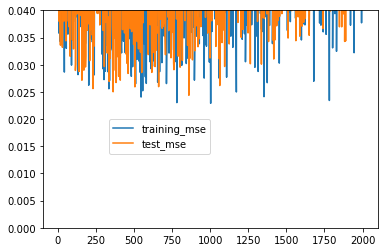

In [33]:
#import seaborn as sns
xcordinates = np.linspace(1,2000, num=len(train_result))
pyplot.plot(xcordinates, train_result, label='training_mse')
pyplot.plot(xcordinates, test_result, label='test_mse')
pyplot.ylim(0.00, 0.04)
pyplot.legend(bbox_to_anchor=(0.5, 0.5), loc=1, borderaxespad=0.)
pyplot.show()

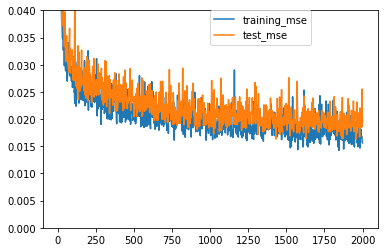

In [56]:
noad_train_result = train_result
noad_test_result = test_result

pyplot.plot(xcordinates, noad_train_result, label='training_mse')
pyplot.plot(xcordinates, noad_test_result, label='test_mse')
pyplot.ylim(0.00, 0.04)
pyplot.legend(bbox_to_anchor=(0.5, 1), loc=2, borderaxespad=0.)
pyplot.show()

## Faces

(5000, 28, 28, 3)
 [*] Reading checkpoints...
NOT found a model === Initializing a new one
EPO: 0, recon_loss: 0.2753
EPO: 0, recon_loss: 0.2594
EPO: 0, recon_loss: 0.2717
EPO: 0, recon_loss: 0.2711
EPO: 0, recon_loss: 0.2690
EPO: 0, recon_loss: 0.2674
EPO: 0, recon_loss: 0.2752
EPO: 1, recon_loss: 0.2615
EPO: 1, recon_loss: 0.2977
EPO: 1, recon_loss: 0.2606
######### what? the reconstruction psnr is: 12.4933


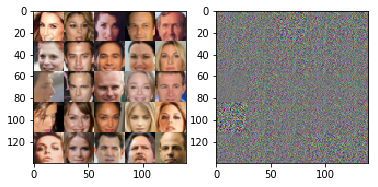

EPO: 1, recon_loss: 0.2836
EPO: 1, recon_loss: 0.2685
EPO: 1, recon_loss: 0.2919
EPO: 1, recon_loss: 0.2757
EPO: 1, recon_loss: 0.2812
EPO: 2, recon_loss: 0.2777
EPO: 2, recon_loss: 0.2613
EPO: 2, recon_loss: 0.2791
EPO: 2, recon_loss: 0.2647
EPO: 2, recon_loss: 0.2913
######### what? the reconstruction psnr is: 12.4936


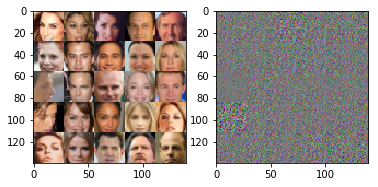

EPO: 2, recon_loss: 0.2766
EPO: 2, recon_loss: 0.2799
EPO: 2, recon_loss: 0.2687
EPO: 3, recon_loss: 0.2804
EPO: 3, recon_loss: 0.2792


KeyboardInterrupt: 

In [67]:
batch_size = 64
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 5
z_dim = 100
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100
sample_set = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:25])
sample_images = next(sample_set.get_batches(25))
sample_images *= 2

tiny_training_set = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[50:550:20])
training_sample_images = next(tiny_training_set.get_batches(25))
training_sample_images *= 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[25:5025])
print(celeba_dataset.shape)

with tf.Graph().as_default():
    train_result, test_result = train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, celeba_dataset.get_batches, 
         sample_images, training_sample_images, celeba_dataset.shape, celeba_dataset.image_mode)


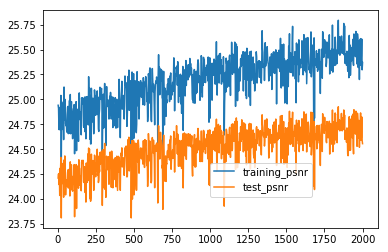

In [57]:
noad_train_result = train_result
noad_test_result = test_result
xcordinates = np.linspace(1,2000, num=len(train_result))
pyplot.plot(xcordinates, noad_train_result, label='training_psnr')
pyplot.plot(xcordinates, noad_test_result, label='test_psnr')
#pyplot.ylim(0.00, 0.04)
pyplot.legend(bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)
pyplot.show()

In [30]:
compare_psnr(sample_images, sample_images + 0.05)

32.041198751719392

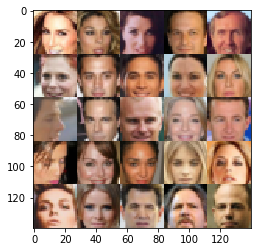

In [52]:
cmap = None
sample_images_grid = helper.images_square_grid(sample_images, celeba_dataset.image_mode)
pyplot.imshow(sample_images_grid, cmap=cmap)
pyplot.show()